In [14]:
# Importation 
!pip install pyAgrum
!pip install pandas 
!pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pyAgrum as gum
import numpy as np
from sklearn.metrics import precision_score

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


## **Create the Bayesian network**

In [5]:
# load the data (only the 4th csv)
calls_dfd = {}
for k in range(4, 5):
    data_filename = f"./calls_a{k}.csv"
    print(f"Chargement du fichier {data_filename}")
    calls_dfd[f"a{k}"] = pd.read_csv(
        data_filename,
        parse_dates=[f"date_a{k_bis}" for k_bis in range(1, k + 1)],
    )

Chargement du fichier calls_a4.csv


In [8]:
#split data into training and testing sets with 70/30 proportions
train_data, test_data = train_test_split(calls_dfd["a4"], test_size=0.3, random_state=42)

In [9]:
# Change the type of categorical variables for the test and train dataset

var_cat = ["weekday_a1", "hour_a1", "weekday_a2", "hour_a2", "weekday_a3", "hour_a3", "weekday_a4", "hour_a4", "caller_has_changed_a2", "caller_has_changed_a3", "caller_has_changed_a4", "lead_answered_a4"]
for var in var_cat:
    train_data[var] = calls_dfd["a4"][var].astype('category')
for var in var_cat:
    test_data[var] = calls_dfd["a4"][var].astype('category')
# Define the models
var_to_model = ["hour_a3", "hour_a4","weekday_a3","weekday_a4","caller_has_changed_a4", "lead_answered_a4"]

var_bn = {}
for var in var_to_model:
        nb_values = len(train_data[var].cat.categories)
        var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

for var in var_bn:
        for i, modalite in enumerate(train_data[var].cat.categories):
            var_bn[var].changeLabel(i, modalite)

bn = gum.BayesNet("simple_model")
for var in var_bn.values():
        bn.add(var)

X = var_to_model[:-1]
for var in X:
        bn.addArc(var, "lead_answered_a4")

learner = gum.BNLearner(train_data[var_to_model])
learner.useSmoothingPrior(1)
learner.useEM(0.01)
learner.fitParameters(bn)



(pyAgrum.BNLearner<double>@000001FCF4076B90) Filename       : C:\Users\tdemo\AppData\Local\Temp\tmpdvk_ywsb.csv
Size           : (143246,6)
Variables      : hour_a3[9], hour_a4[9], weekday_a3[5], weekday_a4[5], caller_has_changed_a4[2], lead_answered_a4[2]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 1.000000
EM             : True
EM epsilon     : 0.010000  (But no missing values in this database)

In [6]:
# use a bayesian network to predict yes or no answers from a dataset
def predict(bn, data, var_target, show_progress=False):
    ie = gum.LazyPropagation(bn)
    predictions = []

    for idx, row in data.iterrows():
        evidence = {col: row[col] for col in data.columns if pd.notnull(row[col])}
        ie.setEvidence(evidence)
        ie.makeInference()
        predictions.append(ie.posterior(var_target).tolist())

        #if show_progress and idx % 100 == 0:
         #   print(f"Processing row {idx}")

    columns = [bn.variable(var_target).label(i) for i in range(bn.variable(var_target).domainSize())]
    return pd.DataFrame(predictions, columns=columns)

# Create a fonction to apply the threshold
def apply_threshold(row, threshold):
    max_prob = row.max()
    if max_prob > threshold:
        return row.idxmax()
    else:
        return "yes" 



In [15]:
# Affichage du réseau bayésien
import pyAgrum.lib.notebook as gnb
gnb.showBN(bn,size=40)

In [12]:
# Predict on the test dataset
pred_prob = predict(bn, data=test_data.loc[:,X],
                    var_target="lead_answered_a4",
                    show_progress=True)

# **Define the best threshold**

In [30]:
# calculate the prediction rate of yes and no for all the thresholds tested 
thresholds = np.arange(0.85,0.95,0.001)
prob_yes= []
prob_no = []
prob_global = []
for threshold in thresholds :
    # get prediction based on threshold
    pred_var = pred_prob.apply(lambda row: row.idxmax() if row.max() > threshold else "yes", axis=1)

    test_data["pred_prob"] = pred_var
    df_yes = test_data.loc[test_data['lead_answered_a4'] == 'yes']
    df_no = test_data.loc[test_data['lead_answered_a4'] == 'no']

    # calculate threshold precision

    true_yes = df_yes['pred_prob'].value_counts()
    no_count_yes = true_yes.get('no', 0)
    yes_count_yes = true_yes.get('yes', 0)

    true_no = df_no['pred_prob'].value_counts()
    no_count_no = true_no.get('no', 0)
    yes_count_no = true_no.get('yes', 0)


    precisionA = yes_count_yes/(no_count_yes+yes_count_yes)
    precisionB = no_count_no/(no_count_no+yes_count_no)

    prob_yes.append(precisionA)
    prob_no.append(precisionB)

    # calculate global precision
    #precision_global = precision_score(test_data['lead_answered_a4'], test_data['pred_prob'], average='micro', zero_division=0)
    #prob_global.append(precision_global)


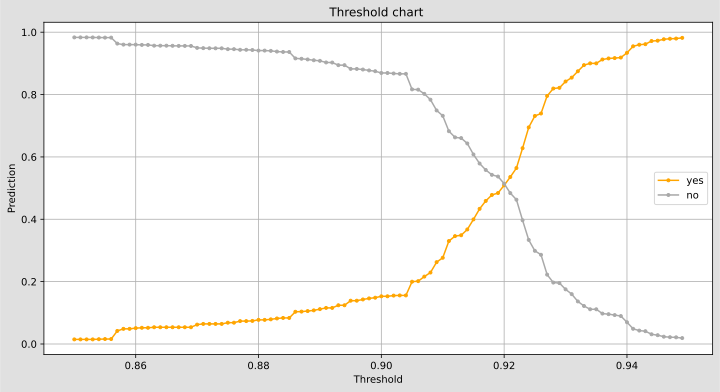

In [23]:
# Create the threshold chart 
plt.figure(figsize=(12, 6))
plt.plot(thresholds, prob_yes, marker='.', label='yes',color="orange")
plt.plot(thresholds, prob_no, marker='.', label='no',color="darkgray")
#plt.plot(thresholds, prob_global, marker='.', label='global')
plt.title('Threshold chart ')
plt.xlabel('Threshold')
plt.ylabel('Prediction')
plt.legend()
plt.grid(True)
plt.show()

## **Best threshold = 0.92**